In [4]:
# Goal: We want to predict who will experience financial distress in the next two years. 
# For this assignment, I assume that a loan-lending company has limited resources and would like to 
# know which individuals to check in with to determine solutions/know which loans are more likley to
# default in advance.
# The company can only check in with 20 individuals per week. Which individuals should the company reach out to?
# Thus, we are interesting in precision in our top 20.

import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Import custom modules
import exploration
import preprocess
import predictions

In [6]:
#ML imports
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [7]:
#Notebook commands
from IPython.display import Image  
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## Tasks:

In this homework, you'll continue to build the Machine Learning pipeline. The goal is to improve the pipeline based on the feedback from previous assignments, and add a few components based on what we've covered in the past few lectures. More specifically, you need to:

Coding Assignment:

1. Fix and improve the pipeline code you submitted for the last assignment based on the feedback from the TAs. if something critical was pointed out in the feedback, you need to fix it. 

2. Add more classifiers to the pipeline. I’d recommend at least having Logistic Regression, K-Nearest Neighbor, Decision Trees, SVM, Random Forests, Boosting, and Bagging. The code should have a parameter for running one or more of these classifiers and your analysis should run all of them.

3. Experiment with different parameters for these classifiers (different values of k for example, as well as parameters that other classifiers have). You should look at the sklearn documentation to see what parameter each classifier can take and what the default values sklearn selects.

4. Add additional evaluation metrics that we've covered in class to the pipeline (accuracy, precision at different levels, recall at different levels, F1, area under curve, and precision-recall curves)

5. Once you've set up the improved pipeline, you can run the data from the last assignment and compare the performance of each classifier on each evaluation metric and other dimensions (such as training/test speed). The code should produce a comparison table.

In [8]:
X_train, X_test, y_train, y_test = exploration.read_data_from_csv("data/credit-data.csv", 0, 
                                                                  True, "SeriousDlqin2yrs", 0.33)
data = X_train.join(y_train)
data.head()

RevolvingUtilizationOfUnsecuredLines  age  zipcode  \
PersonID                                                       
87936                                 0.000000   68    60804   
3893                                  1.000000   34    60644   
41405                                 1.000666   39    60637   
91125                                 0.653085   52    60629   
67373                                 1.000000   54    60625   

          NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
PersonID                                                                     
87936                                        0   798.000000            NaN   
3893                                         0     0.058946         4325.0   
41405                                        0  1911.000000            NaN   
91125                                        0     0.203020         4900.0   
67373                                        3   779.000000            NaN   

          NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
PersonID                                                             
87936                                   4                        0   
3893                                    2                        0   
41405                                   5                        0   
91125                                  10                        0   
67373                                   5                        2   

          NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
PersonID                                                                       
87936                                1                                     0   
3893                                 0                                     0   
41405                                2                                     0   
91125                                0                                     0   
67373                                1                                     2   

          NumberOfDependents  SeriousDlqin2yrs  
PersonID                                        
87936                    0.0                 0  
3893                     0.0                 0  
41405                    0.0                 0  
91125                    2.0                 0  
67373                    NaN                 1

----
# Exploring data

In [9]:
# General description of data.
print("Dimension of train dataset: {} rows and {} features.\n".format(data.shape[0], data.shape[1]))
data.describe()

Dimension of train dataset: 100500 rows and 12 features.



RevolvingUtilizationOfUnsecuredLines            age        zipcode  \
count                         100500.000000  100500.000000  100500.000000   
mean                               5.459191      52.281841   60648.638239   
std                              210.022307      14.780930      56.640170   
min                                0.000000      21.000000   60601.000000   
25%                                0.029980      41.000000   60625.000000   
50%                                0.155435      52.000000   60629.000000   
75%                                0.560897      63.000000   60644.000000   
max                            29110.000000     109.000000   60804.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         100500.000000  100500.000000   8.066300e+04   
mean                               0.435910     349.759787   6.637161e+03   
std                                4.335404    1782.139436   1.193133e+04   
min                                0.000000       0.000000   0.000000e+00   
25%                                0.000000       0.175145   3.400000e+03   
50%                                0.000000       0.366655   5.400000e+03   
75%                                0.000000       0.868521   8.249000e+03   
max                               98.000000  307001.000000   1.794060e+06   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                    100500.000000            100500.000000   
mean                          8.457473                 0.279174   
std                           5.141521                 4.313026   
min                           0.000000                 0.000000   
25%                           5.000000                 0.000000   
50%                           8.000000                 0.000000   
75%                          11.000000                 0.000000   
max                          57.000000                98.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                 100500.000000                         100500.000000   
mean                       1.018478                              0.252667   
std                        1.120661                              4.298975   
min                        0.000000                              0.000000   
25%                        0.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                       32.000000                             98.000000   

       NumberOfDependents  SeriousDlqin2yrs  
count        97874.000000     100500.000000  
mean             0.759109          0.067393  
std              1.118766          0.250703  
min              0.000000          0.000000  
25%              0.000000          0.000000  
50%              0.000000          0.000000  
75%              1.000000          0.000000  
max             13.000000          1.000000

In [10]:
# What is the distribution of our target variable?
data.SeriousDlqin2yrs.value_counts()
data.SeriousDlqin2yrs.value_counts(normalize=True)

0    93727
1     6773
Name: SeriousDlqin2yrs, dtype: int64

0    0.932607
1    0.067393
Name: SeriousDlqin2yrs, dtype: float64

We are trying to predict who experiences 90 days past due delinquency or worse. In our dataset, this only occurs in 6.6% of the cases.

60625    0.223662
60618    0.112209
60629    0.111731
60637    0.111711
60601    0.111055
60644    0.110100
60804    0.110100
60657    0.109433
Name: zipcode, dtype: float64

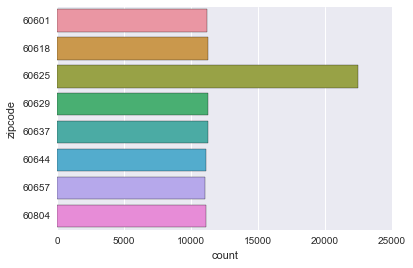

In [11]:
# Are ZIP codes equally represented?
data.zipcode.value_counts(normalize=True)
_ = sns.countplot(y="zipcode", data=data)

We only have data from 8 zip codes. The data looks equally distributed across zip codes, except for 60625 being responsible for 22% of the entries.

In [12]:
# How is our target variable distributed by ZIP code?
cross_table = pd.crosstab(data.zipcode, data.SeriousDlqin2yrs)
cross_table["total"] = cross_table[0] + cross_table[1]
cross_table["perc_of_SeriousDlqin2yrs"] = cross_table[1] / cross_table["total"]
cross_table

SeriousDlqin2yrs      0     1  total  perc_of_SeriousDlqin2yrs
zipcode                                                       
60601             10424   737  11161                  0.066034
60618             10530   747  11277                  0.066241
60625             20969  1509  22478                  0.067132
60629             10502   727  11229                  0.064743
60637             10469   758  11227                  0.067516
60644             10294   771  11065                  0.069679
60657             10250   748  10998                  0.068012
60804             10289   776  11065                  0.070131

While the ZIP code 60625 has the most entries in the dataset, the relative rate of individuals experiencing 90 days past due delinquency or worse is relatively stable across all ZIP codes.

In [13]:
# What is the mean of a variable for target = 1 and target = 0?
data.groupby("SeriousDlqin2yrs").mean()

RevolvingUtilizationOfUnsecuredLines        age  \
SeriousDlqin2yrs                                                    
0                                             5.574359  52.747415   
1                                             3.865456  45.839067   

                       zipcode  NumberOfTime30-59DaysPastDueNotWorse  \
SeriousDlqin2yrs                                                       
0                 60648.569164                              0.284262   
1                 60649.594124                              2.534475   

                   DebtRatio  MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
SeriousDlqin2yrs                                                               
0                 353.424513    6716.737005                         8.497786   
1                 299.046113    5581.459851                         7.899601   

                  NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
SeriousDlqin2yrs                                                          
0                                0.136684                      1.020656   
1                                2.250997                      0.988336   

                  NumberOfTime60-89DaysPastDueNotWorse  NumberOfDependents  
SeriousDlqin2yrs                                                            
0                                             0.128159            0.746169  
1                                             1.975639            0.936673

On average, individuals experiencing 90 days past due delinquency or worse ...
    - are younger (45.8 vs 52.75)
    - have a lower income (5581 vs 6716)
    - have a lower debt ratio (299 vs 353). However, these means are likely influenced by outliers or come from cases without monthly income/ with no reported income. Therefore, this comparison only holds if we assume that no income/no reported income shows same distribution across target variable.
    - have a lower amount of open credit lines and loans (7.89 vs 8.5)
    - have more dependents (0.94 vs 0.75)
    - have been more often 30-59/60-89/90 days past due but no worse in the last 2 years.

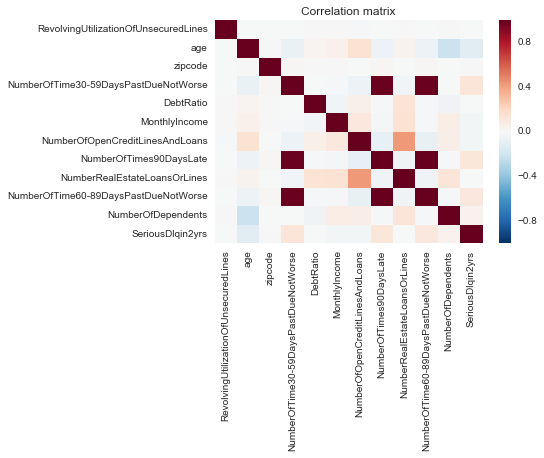

In [14]:
# How are the variables correlated with each other?
exploration.plot_correlations(data, 'Correlation matrix')

_Answer:_ 

There is a __moderate__ positive correlation between our target variable _SeriousDlqin2yrs_ and:
    - NumberOfTime30-59DaysPastDueNotWorse
    - NumberOfTime60-89DaysPastDueNotWorse
    - NumberOfTime90DaysLate
    
There is a __small__ positive correlation between our target variable _SeriousDlqin2yrs_ and:
    - NumberOfDependents
   
There is a __small__ negative correlation between our target variable _SeriousDlqin2yrs_ and:
    - age

----
# Pre-Processing

In [15]:
data.head()

RevolvingUtilizationOfUnsecuredLines  age  zipcode  \
PersonID                                                       
87936                                 0.000000   68    60804   
3893                                  1.000000   34    60644   
41405                                 1.000666   39    60637   
91125                                 0.653085   52    60629   
67373                                 1.000000   54    60625   

          NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
PersonID                                                                     
87936                                        0   798.000000            NaN   
3893                                         0     0.058946         4325.0   
41405                                        0  1911.000000            NaN   
91125                                        0     0.203020         4900.0   
67373                                        3   779.000000            NaN   

          NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
PersonID                                                             
87936                                   4                        0   
3893                                    2                        0   
41405                                   5                        0   
91125                                  10                        0   
67373                                   5                        2   

          NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
PersonID                                                                       
87936                                1                                     0   
3893                                 0                                     0   
41405                                2                                     0   
91125                                0                                     0   
67373                                1                                     2   

          NumberOfDependents  SeriousDlqin2yrs  
PersonID                                        
87936                    0.0                 0  
3893                     0.0                 0  
41405                    0.0                 0  
91125                    2.0                 0  
67373                    NaN                 1

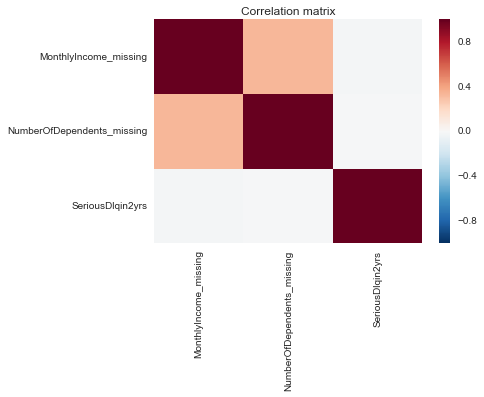

In [16]:
categorical_vars = ['zipcode']

new_columns = preprocess.keep_track_of_missing_values(data, "_missing")
data = preprocess.fill_missing_categorical_values(data, categorical_vars)
data = preprocess.fill_missing_values(data)

#Are the missing values correlated with our target?
exploration.plot_correlations(data[new_columns + ["SeriousDlqin2yrs"]], 'Correlation matrix')

There is no correlation between missing values and our target _SeriousDlqin2yrs_.

----
# Building Features

In [17]:
# setting test's zipcode as category with attributes from train to ensure 
# same columns in train and test set.
X_test["zipcode"] = X_test["zipcode"].astype('category', categories=X_train.zipcode.unique())

# We will use this code to identify discretized dummy vars
dummy_code = "_XX_disc"

# modifying variables
data = preprocess.dummify_var(data, categorical_vars)
data = preprocess.discretize_cont_var(data, "age", 10, dummy_code)

----
# Preprocessing Test Set

In [18]:
#We will use the preprocessed data as training data
X_train = data.drop(["SeriousDlqin2yrs"], axis=1)

In [19]:
# Do we have similar % of target in train and test?
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

0    0.932607
1    0.067393
Name: SeriousDlqin2yrs, dtype: float64

0    0.934283
1    0.065717
Name: SeriousDlqin2yrs, dtype: float64

In [20]:
#keeping track of missing values (but only in same columns as train data)
preprocess.create_missing_value_colum_in_testset(X_train, X_test, "_missing")

#fill empty values
X_test = preprocess.fill_missing_categorical_values(X_test, categorical_vars)
X_test = preprocess.fill_missing_values(X_test)

# ensuring that X_test has the same columns as X_train
X_test = preprocess.dummify_var(X_test, categorical_vars)
col_to_value_dict = preprocess.build_col_to_value_dict(X_train, dummy_code)
X_test = preprocess.insert_discretize_quantiles(X_test, col_to_value_dict)

----
# Training Simple Classifiers

In [21]:
# It is unlikely that an individual is delinquent. 
# How well can we predict if we randomly predict 
# according to mean of training data?

In [22]:
#First, we normalize features as some classifiers assume normalized data
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, 
                                                                    test_size=0.3, random_state=0)

# We learn normalization from X_train_val; store it and apply it to X_test_val
scaler = preprocessing.StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val) 
X_test_val = scaler.transform(X_test_val) 
X_test = scaler.transform(X_test)

In [23]:
# Let's train some easy classifiers

easy_cls_dict = {'AvgPred': (predictions.Average_Predictor(), None),
                 'RandomPred': (predictions.Average_Predictor(), np.array([0,1])),
                 'ZeroPred': (predictions.Zero_Predictor(), None),
                }

for cls_name, cls_tuple in easy_cls_dict.items():
    print("Fitting ", cls_name)
    cls, target = cls_tuple
    if (target is not None):
        cls.fit(target)
    else:
        cls.fit(y_train_val)
    
    acc_score = cls.score(X_test_val, y_test_val, 'accuracy')
    prec_score = cls.score(X_test_val, y_test_val, 'precision')
    print(cls_name, "achieves scores of:")
    print("\tacc_score: {}\n\tprec_score: {}\n".format(acc_score, prec_score))

Fitting  ZeroPred
ZeroPred achieves scores of:
	acc_score: 0.9342951907131012
	prec_score: 0

Fitting  RandomPred
RandomPred achieves scores of:
	acc_score: 0.5029850746268656
	prec_score: 0.06452892561983471

Fitting  AvgPred
AvgPred achieves scores of:
	acc_score: 0.8756218905472637
	prec_score: 0.07238734419942473



__Average Predictor__: When we only predict that an individual is delinquent according to the probability of delinquency (predict delinquency when random number is less than mean of y_train_val), we achieve an accuracy of 0.87 on our hold-out set from the training data. Using the same approach we achieve a precision of 0.062 -> of all the cases where our algorithm says that the individual will face financial problems, only 6% of the individuals actually face financial problems.

__Random Predictor__: When we only predict that an individual is delinquent according to chance, we achieve an accuracy of 0.5 on our hold-out set from the training data. Using the same approach we achieve a precision of 0.065 -> of all the cases where our algorithm says that the individual will face financial problems, only 6.5% of the individuals actually face financial problems.

__Zero Predictor__: When we always predict that an individual is not delinquent, we achieve an accuracy of 0.93 on our hold-out set from the training data. However, we also never predict that an individual faces financial problems, which is not useful for this application.

----
# Training ML models

In [24]:
# Training models on train, finding best on validation; re-training best on combined train and validation; reporting performance
# on fresh test set

LR


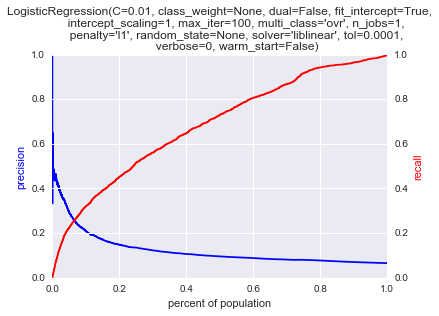

NN


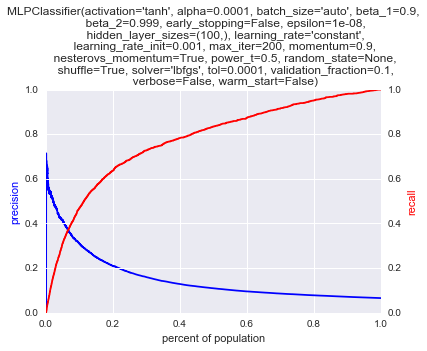

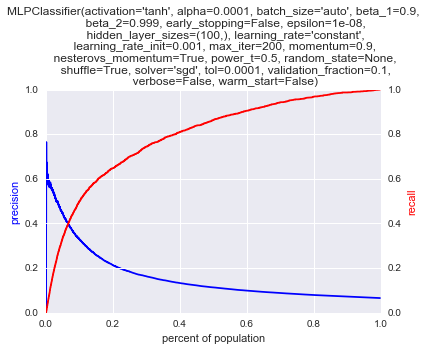

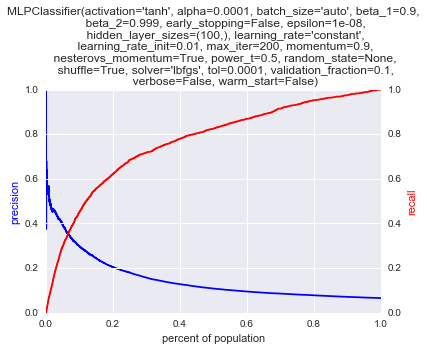

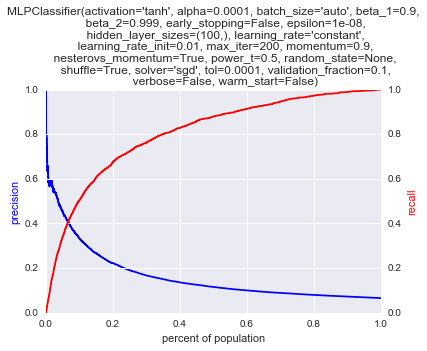

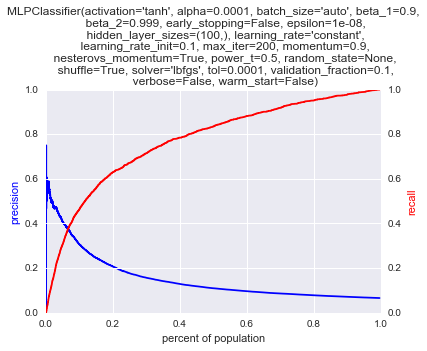

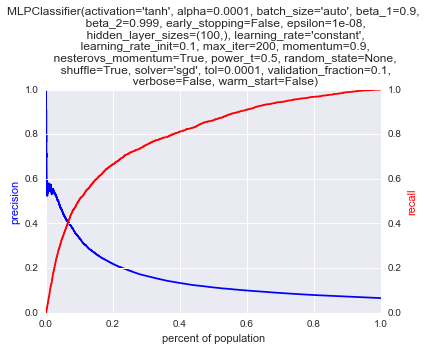

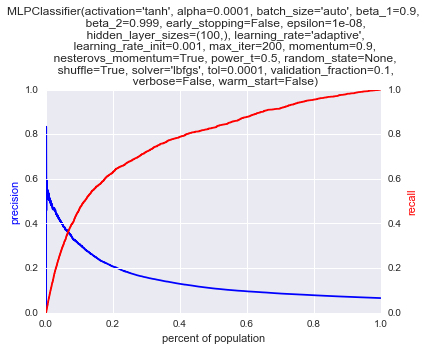

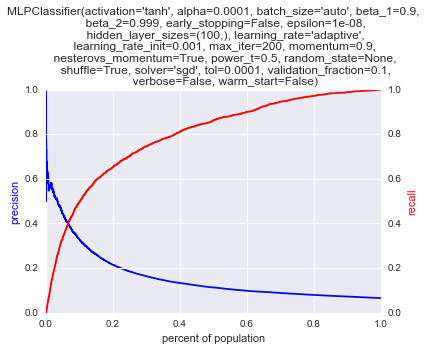

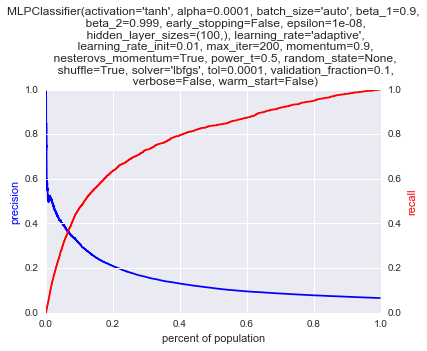

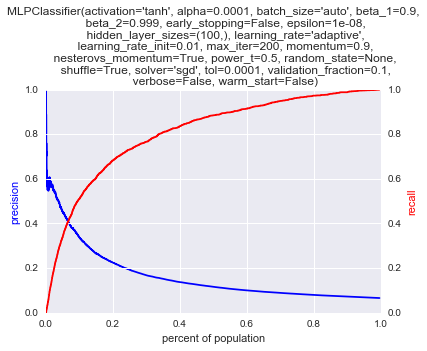

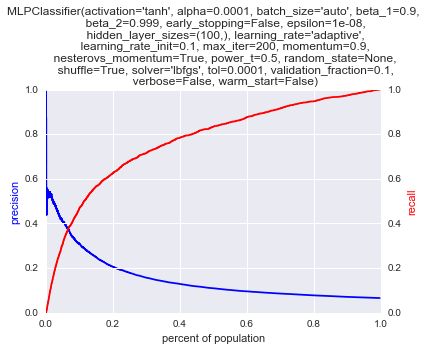

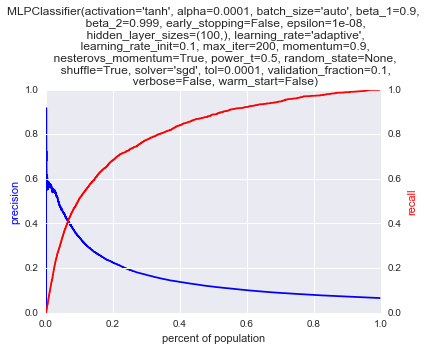

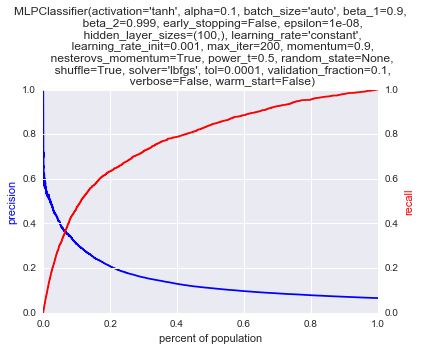

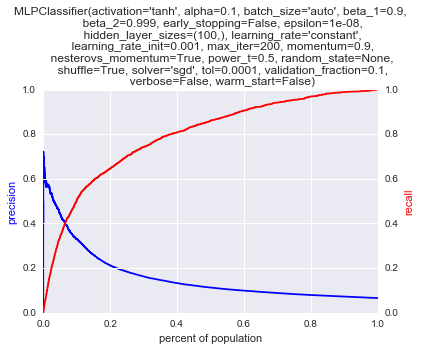

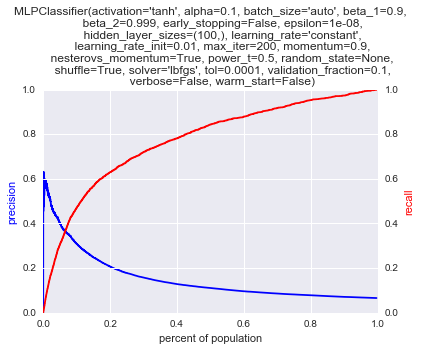

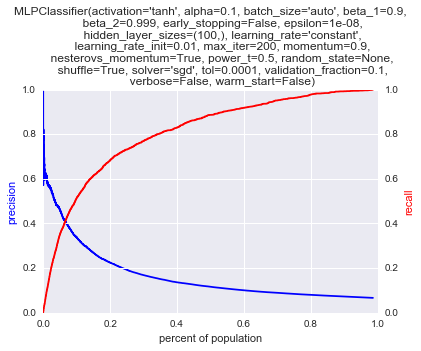

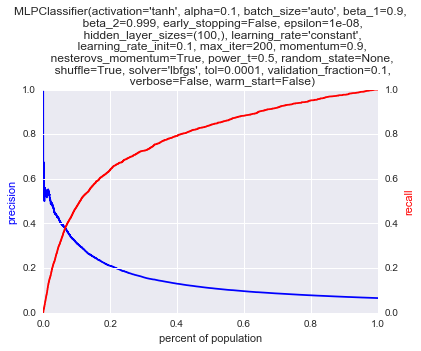

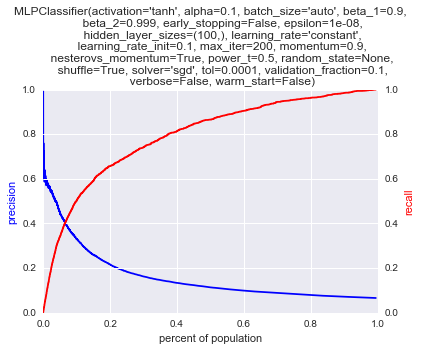

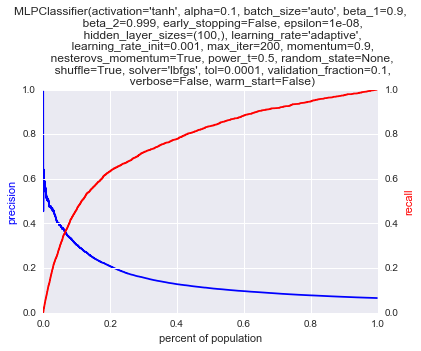

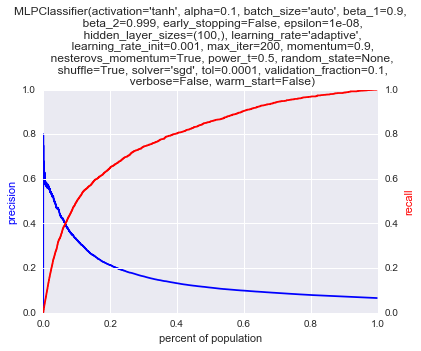

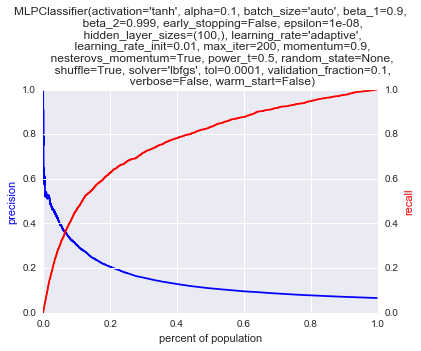

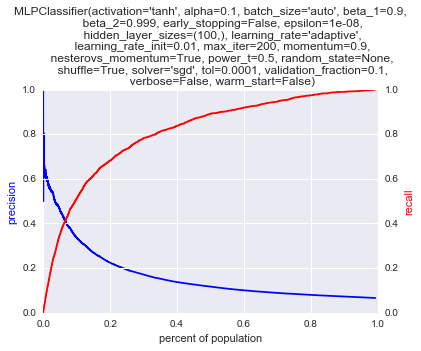

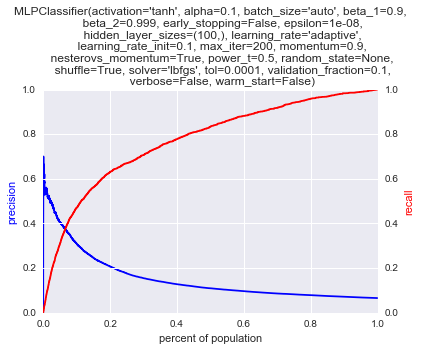

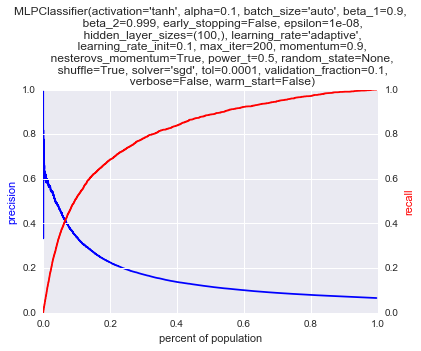

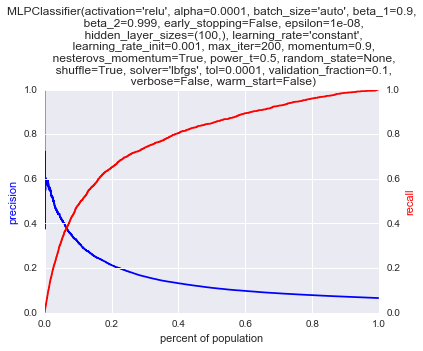

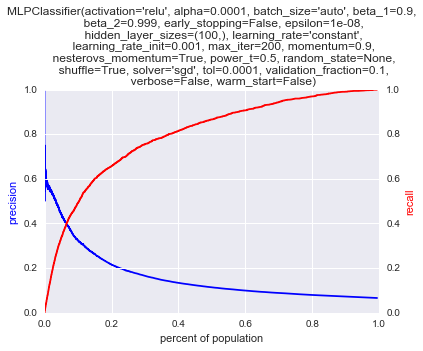

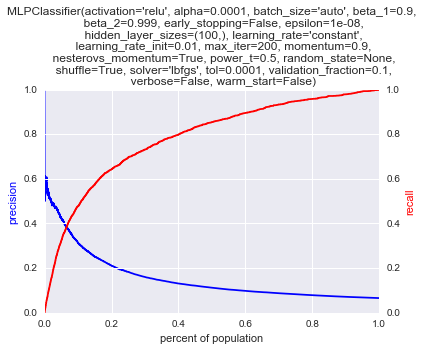

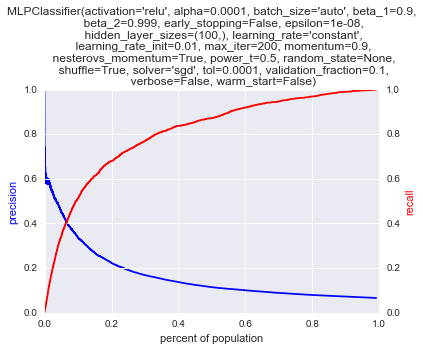

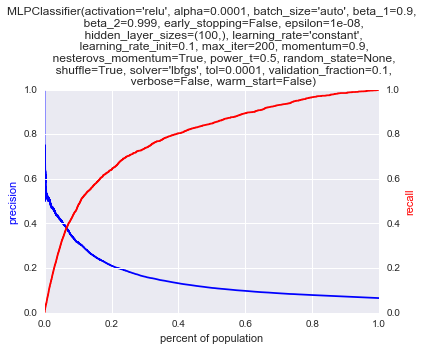

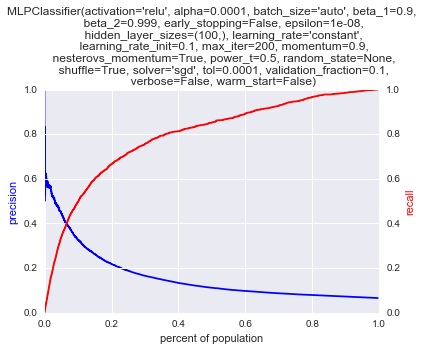

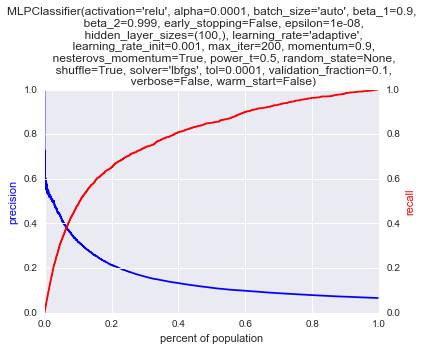

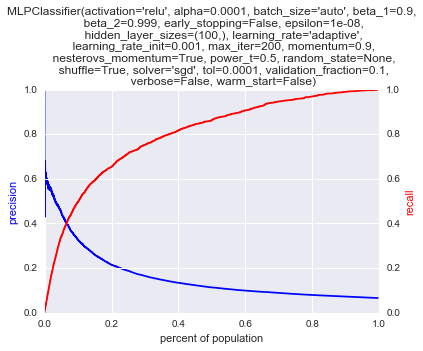

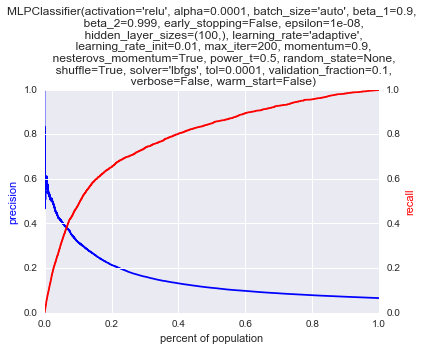

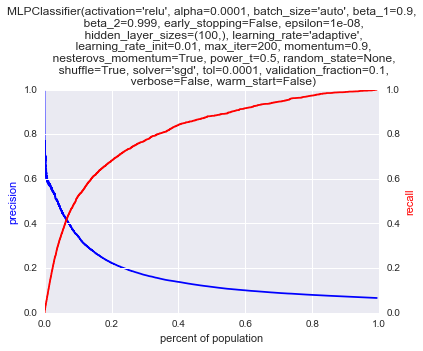

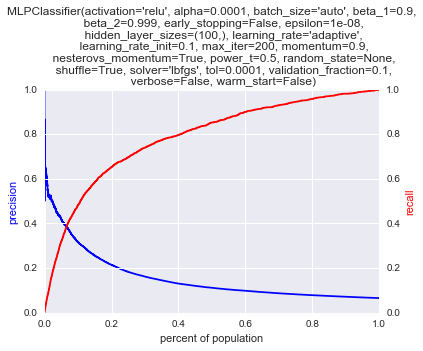

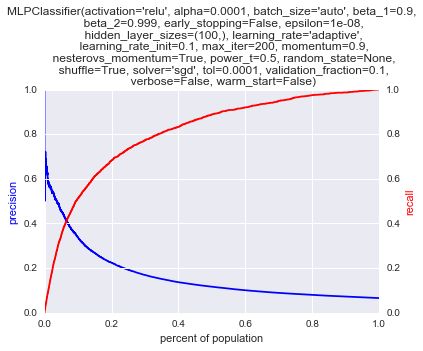

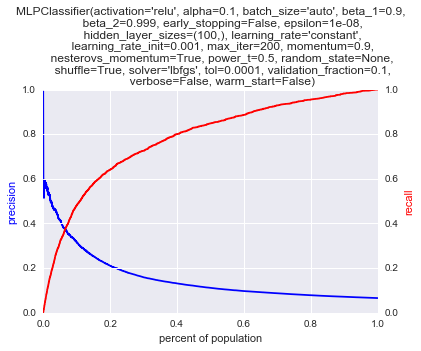

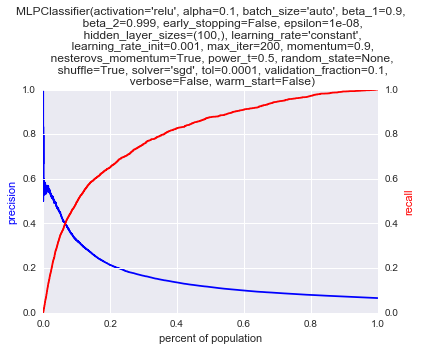

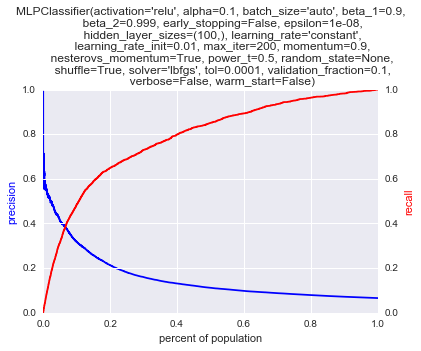

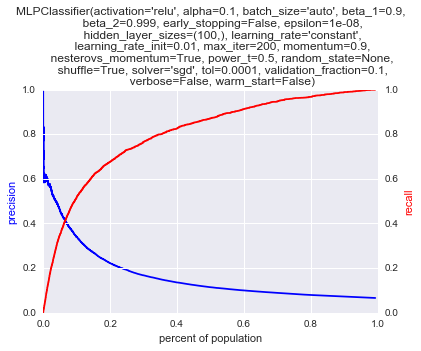

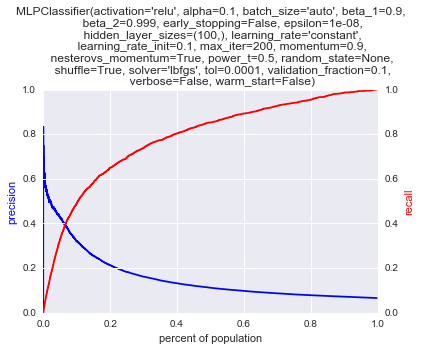

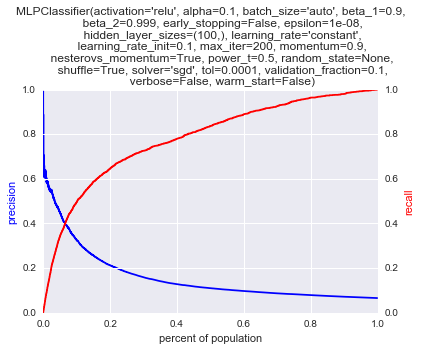

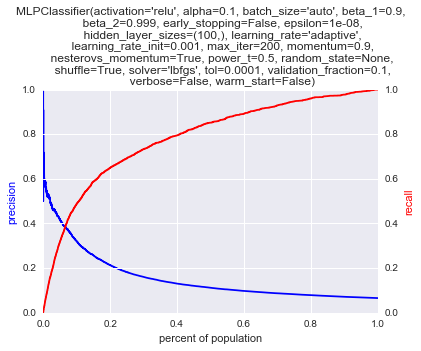

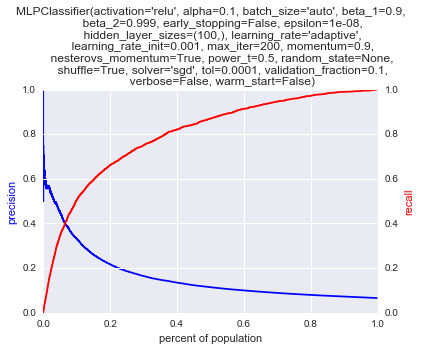

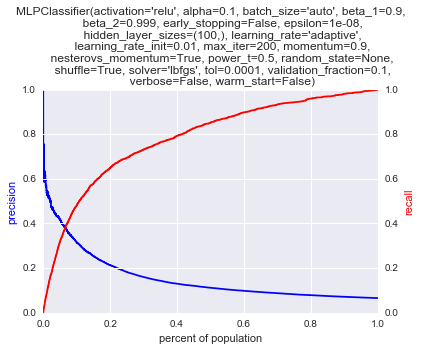

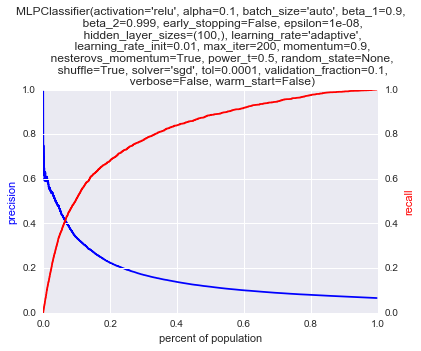

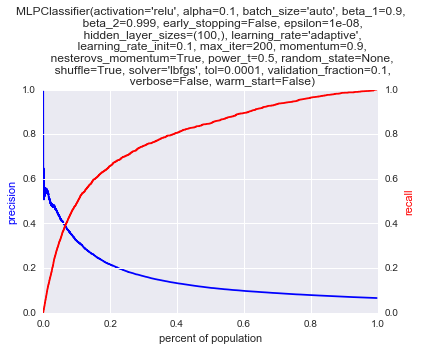

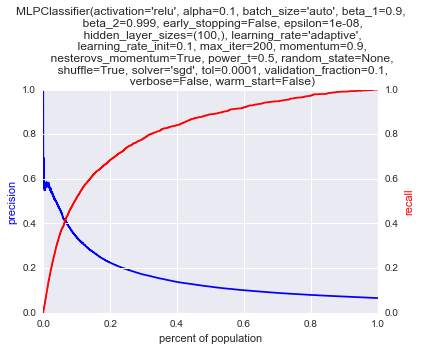

model_type                                                clf  \
0         LR  LogisticRegression(C=0.01, class_weight=None, ...   
1         LR  LogisticRegression(C=0.01, class_weight=None, ...   
2         LR  LogisticRegression(C=0.01, class_weight=None, ...   
3         LR  LogisticRegression(C=0.01, class_weight=None, ...   
4         LR  LogisticRegression(C=0.01, class_weight=None, ...   

                     parameters  train_time  predict_time  threshold  \
0  {'penalty': 'l1', 'C': 0.01}    6.674935      0.002207       0.10   
1  {'penalty': 'l1', 'C': 0.01}    6.674935      0.002207       0.15   
2  {'penalty': 'l1', 'C': 0.01}    6.674935      0.002207       0.20   
3  {'penalty': 'l1', 'C': 0.01}    6.674935      0.002207       0.25   
4  {'penalty': 'l1', 'C': 0.01}    6.674935      0.002207       0.30   

    auc-roc  p_at_1  p_at_20  p_at_50     ...      p_at_150  p_at_200  \
0  0.696925     1.0     0.65      0.5     ...      0.466667  0.445000   
1  0.696925     1.0     0.65      0.5     ...      0.466667  0.445000   
2  0.696925     1.0     0.65      0.5     ...      0.466667  0.445000   
3  0.696925     1.0     0.65      0.5     ...      0.466667  0.477419   
4  0.696925     1.0     0.65      0.5     ...      0.464646  0.464646   

   p_at_All  rec_at_1  rec_at_20  rec_at_50  rec_at_100  rec_at_150  \
0  0.169828       1.0        1.0        1.0         1.0    1.000000   
1  0.379630       1.0        1.0        1.0         1.0    1.000000   
2  0.456522       1.0        1.0        1.0         1.0    1.000000   
3  0.477419       1.0        1.0        1.0         1.0    1.000000   
4  0.464646       1.0        1.0        1.0         1.0    0.657143   

   rec_at_200  rec_at_All  
0    1.000000    0.393236  
1    1.000000    0.144876  
2    1.000000    0.063604  
3    0.831461    0.037355  
4    0.516854    0.023221  

[5 rows x 21 columns]

In [25]:
start_time = time.time()

grid_size = 'test'
clfs, grid = predictions.define_clfs_params(grid_size)

models_to_run= ['RF', 'DT', 'KNN', 'ET', 'AB', 'GB', 'LR', 'NB', 'SVM', 'NN']
models_to_run= ['LR', 'NN']
list_ks = [1, 20, 50, 100, 150, 200, "All"]
list_thresholds = np.arange(0.1, 1.05, 0.05)

results_df = predictions.clf_loop(models_to_run, clfs, grid, X_train_val, X_test_val, 
                                  y_train_val, y_test_val, list_ks, list_thresholds, print_plots = True)
results_df.head()
results_df.to_csv('results.csv', index=False)

took_time = time.time() - start_time

In [26]:
print("Done training on grid size: {}. It took {} min".format(grid_size, took_time / 60))

Done training on grid size: test. It took 32.593165834744774 min


----
# Training with Random Undersampling of Majority Class

In [27]:
# Using random undersampling of the majority class before training the classifiers.
rus = RandomUnderSampler(random_state=42)
X_train_undersample, y_train_undersample = rus.fit_sample(X_train, y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_undersample)))

X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train_undersample, y_train_undersample, 
                                                                    test_size=0.3, random_state=0)

Original dataset shape Counter({0: 93727, 1: 6773})
Resampled dataset shape Counter({0: 6773, 1: 6773})


LR


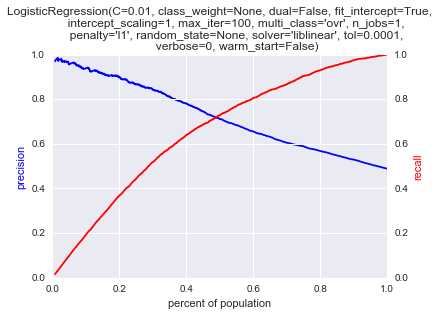

NN


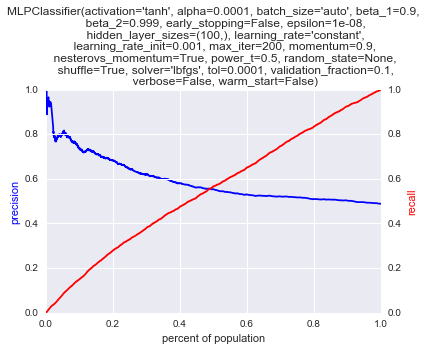

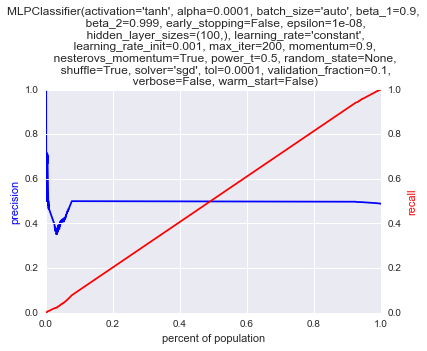

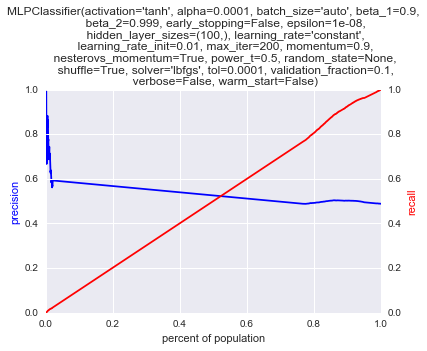

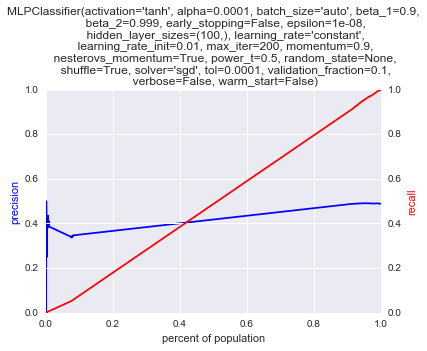

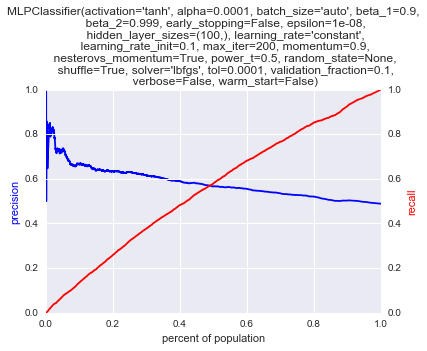

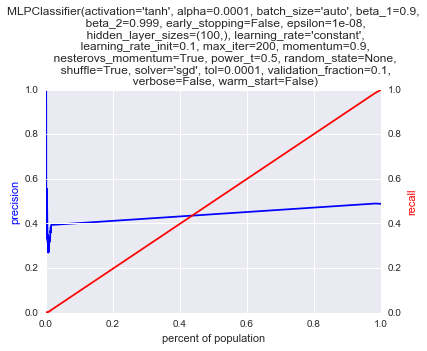

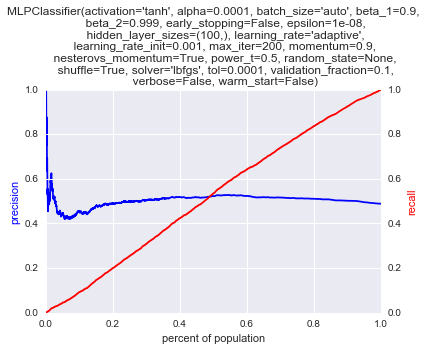

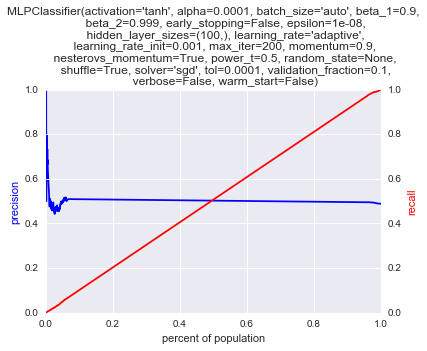

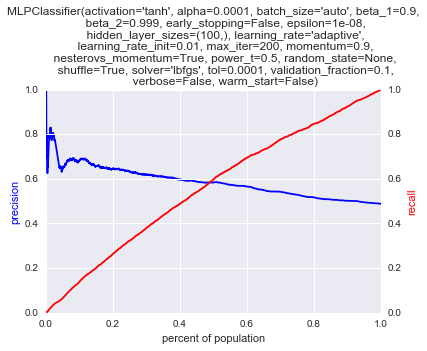

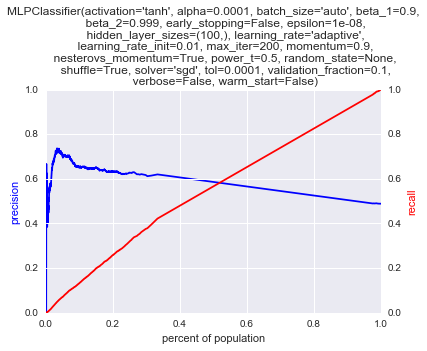

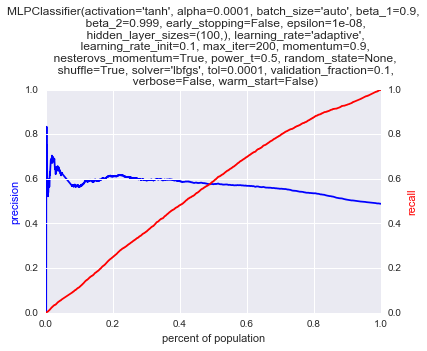

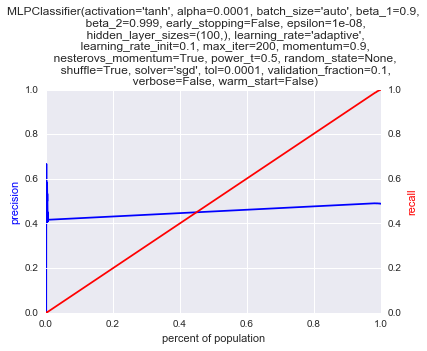

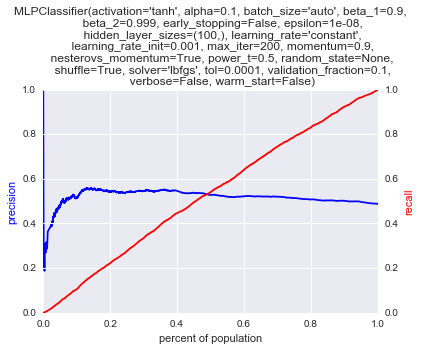

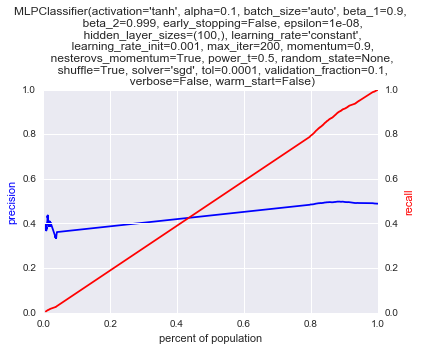

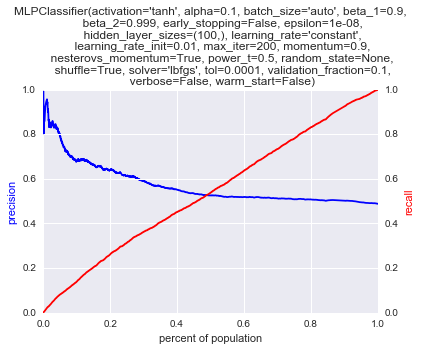

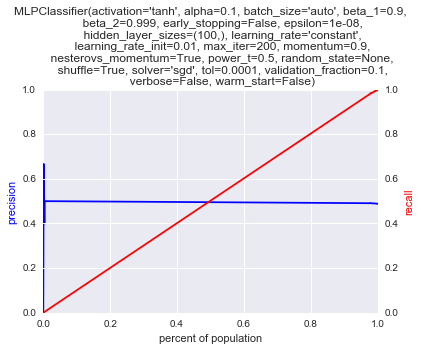

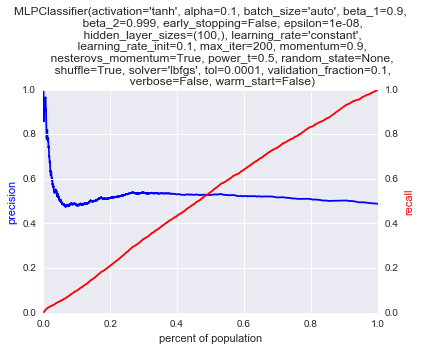

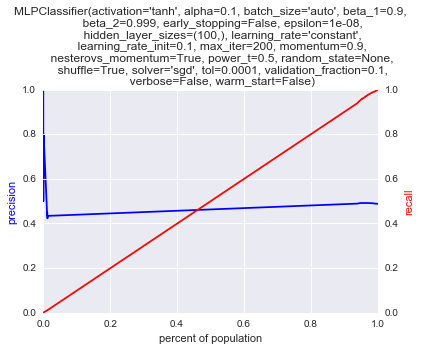

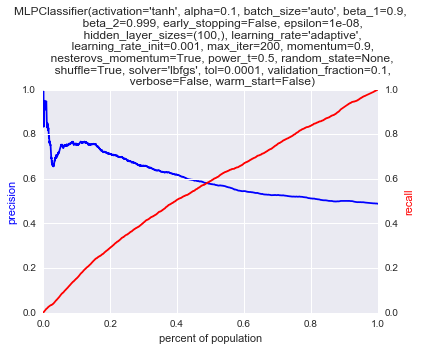

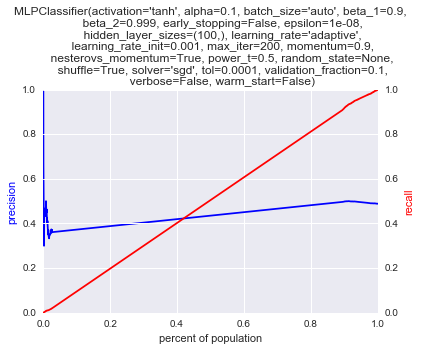

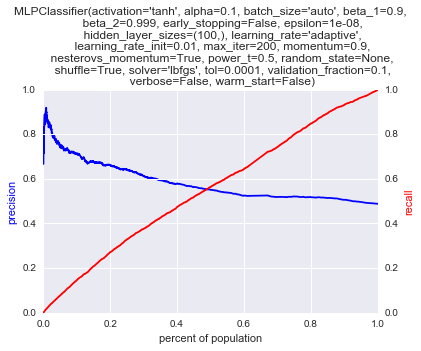

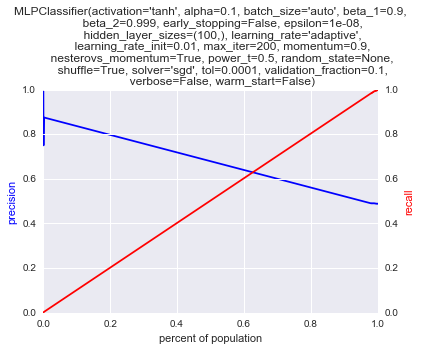

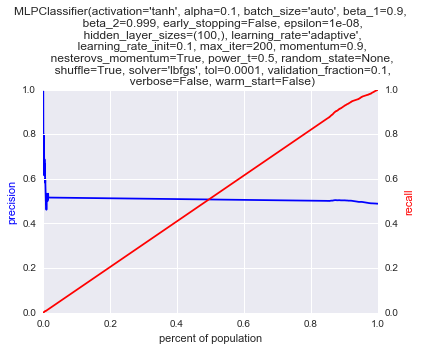

/Users/hannes/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


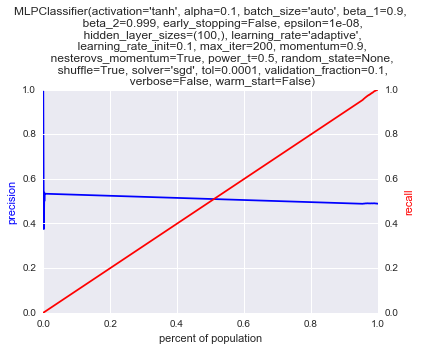

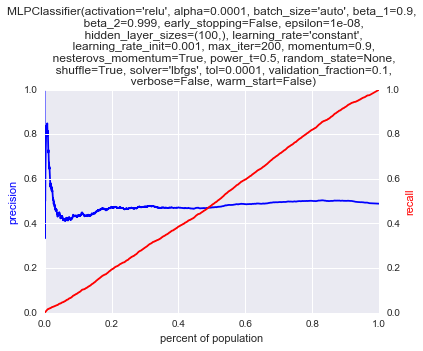

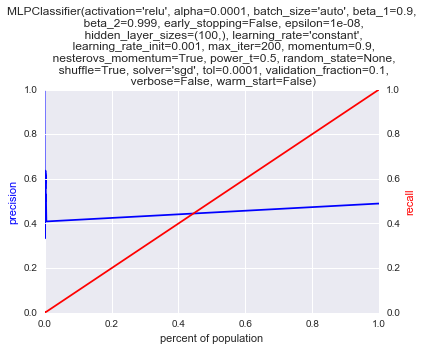

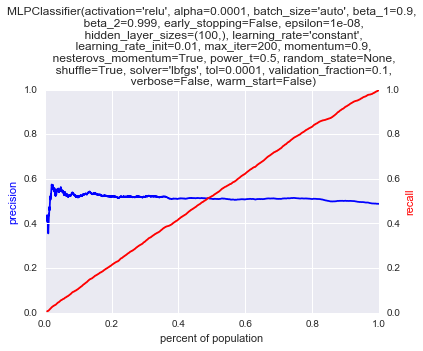

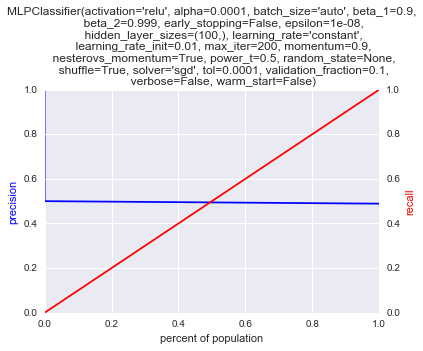

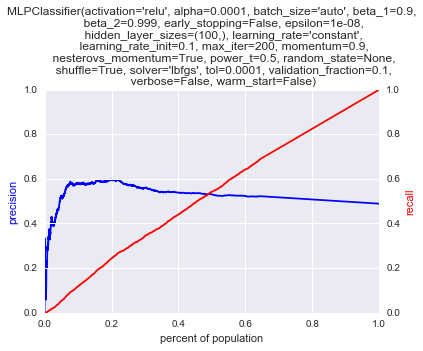

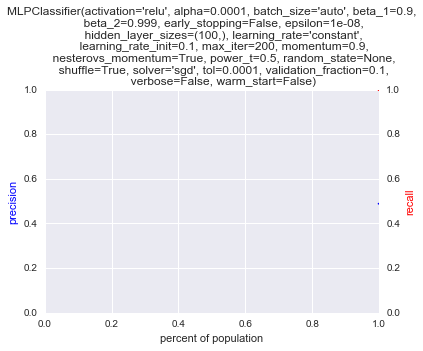

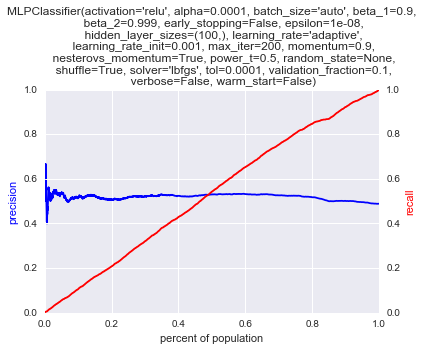

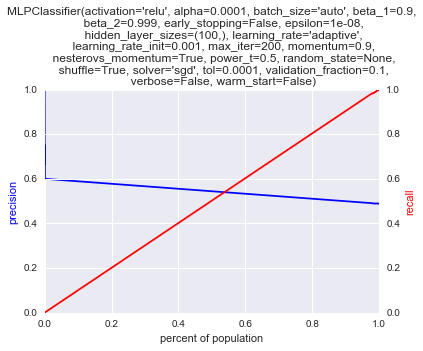

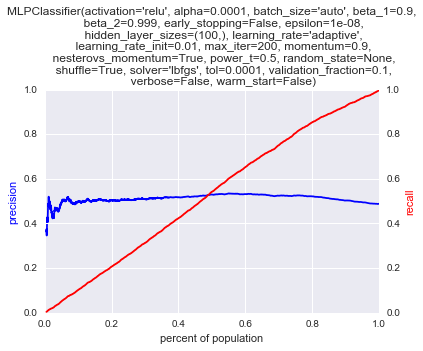

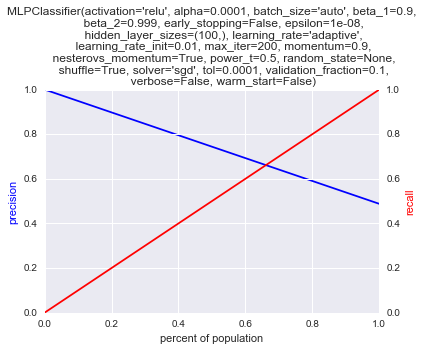

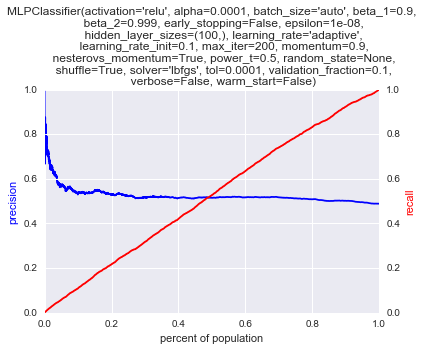

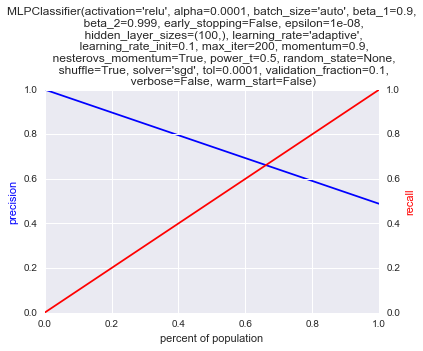

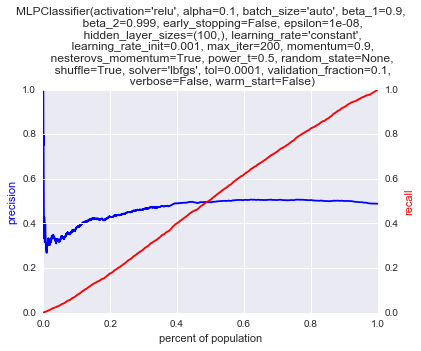

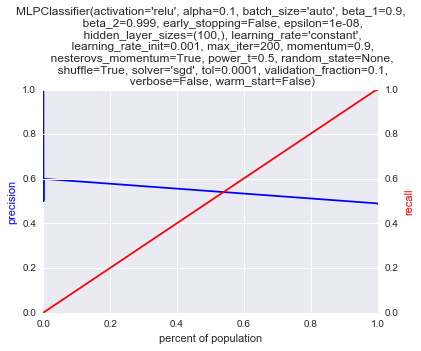

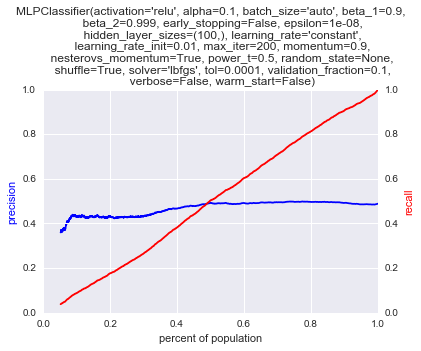

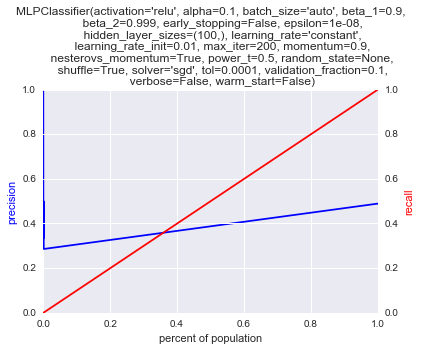

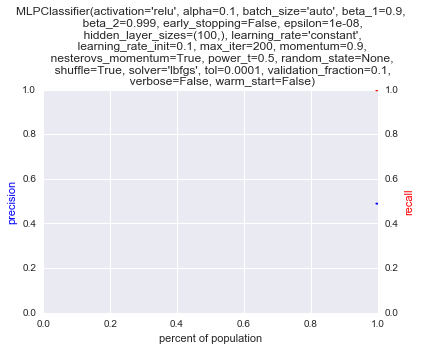

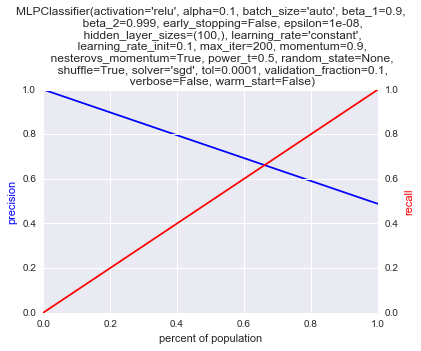

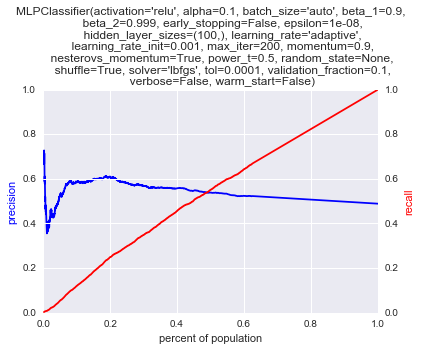

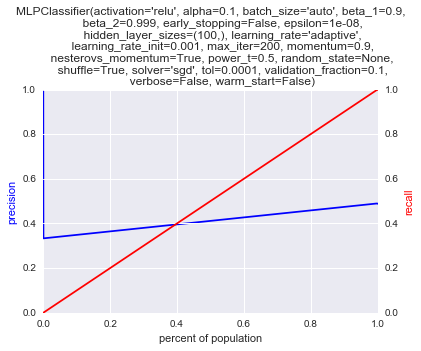

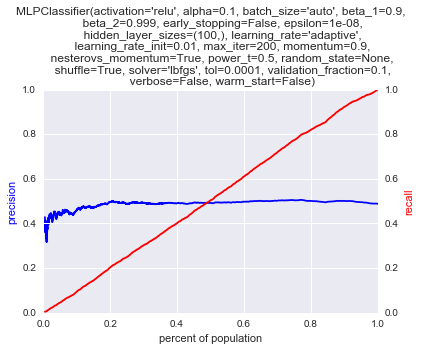

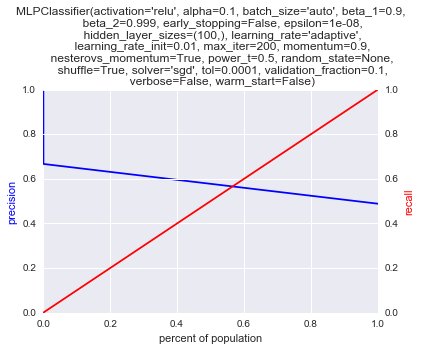

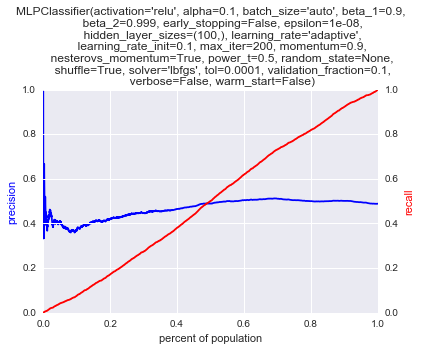

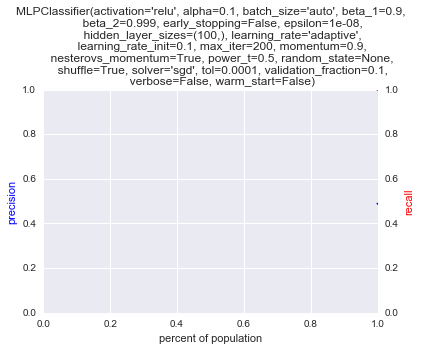

model_type                                                clf  \
0         LR  LogisticRegression(C=0.01, class_weight=None, ...   
1         LR  LogisticRegression(C=0.01, class_weight=None, ...   
2         LR  LogisticRegression(C=0.01, class_weight=None, ...   
3         LR  LogisticRegression(C=0.01, class_weight=None, ...   
4         LR  LogisticRegression(C=0.01, class_weight=None, ...   

                     parameters  train_time  predict_time  threshold  \
0  {'penalty': 'l1', 'C': 0.01}    0.071916      0.000515       0.30   
1  {'penalty': 'l1', 'C': 0.01}    0.071916      0.000515       0.35   
2  {'penalty': 'l1', 'C': 0.01}    0.071916      0.000515       0.40   
3  {'penalty': 'l1', 'C': 0.01}    0.071916      0.000515       0.45   
4  {'penalty': 'l1', 'C': 0.01}    0.071916      0.000515       0.50   

    auc-roc  p_at_1  p_at_20  p_at_50     ...      p_at_150  p_at_200  \
0  0.799883     1.0      1.0     0.98     ...      0.966667     0.955   
1  0.799883     1.0      1.0     0.98     ...      0.966667     0.955   
2  0.799883     1.0      1.0     0.98     ...      0.966667     0.955   
3  0.799883     1.0      1.0     0.98     ...      0.966667     0.955   
4  0.799883     1.0      1.0     0.98     ...      0.966667     0.955   

   p_at_All  rec_at_1  rec_at_20  rec_at_50  rec_at_100  rec_at_150  \
0  0.523950       1.0        1.0        1.0         1.0         1.0   
1  0.575528       1.0        1.0        1.0         1.0         1.0   
2  0.635909       1.0        1.0        1.0         1.0         1.0   
3  0.726332       1.0        1.0        1.0         1.0         1.0   
4  0.818841       1.0        1.0        1.0         1.0         1.0   

   rec_at_200  rec_at_All  
0         1.0    0.980363  
1         1.0    0.918933  
2         1.0    0.832830  
3         1.0    0.706949  
4         1.0    0.568983  

[5 rows x 21 columns]

In [28]:
results_df_undersampling = predictions.clf_loop(models_to_run, clfs, grid, X_train_val, X_test_val, 
                                  y_train_val, y_test_val, list_ks, list_thresholds, print_plots = True)
results_df_undersampling.head()
results_df_undersampling.to_csv('results_undersampling.csv', index=False)

----
# Training with Random Oversampling of Minorty Class

In [30]:
# Using random oversampling of the majority class before training the classifiers.
rus = RandomOverSampler(random_state=42)
X_train_oversample, y_train_oversample = rus.fit_sample(X_train, y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_oversample)))

X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train_oversample, y_train_oversample, 
                                                                    test_size=0.3, random_state=0)

Original dataset shape Counter({0: 93727, 1: 6773})
Resampled dataset shape Counter({0: 93727, 1: 93727})


LR


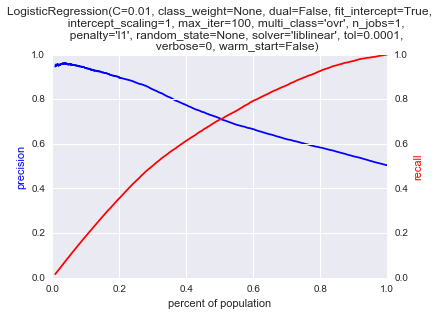

NN


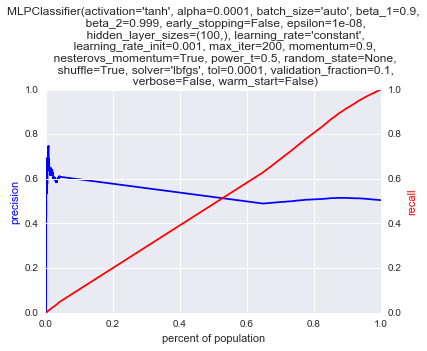

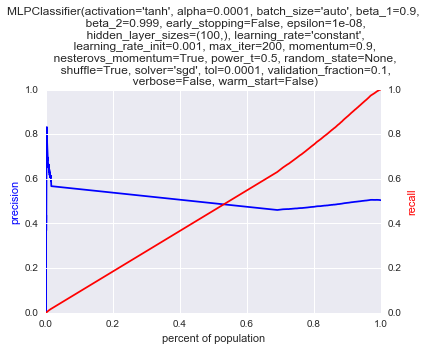

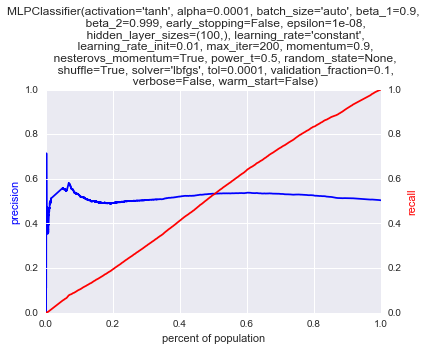

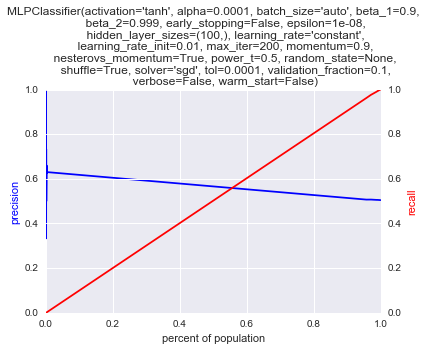

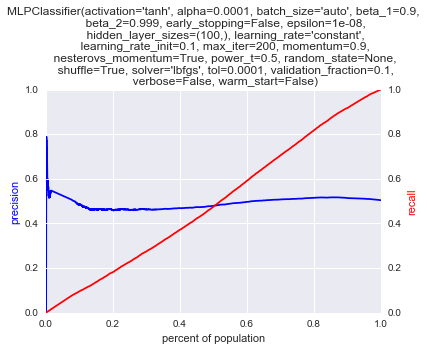

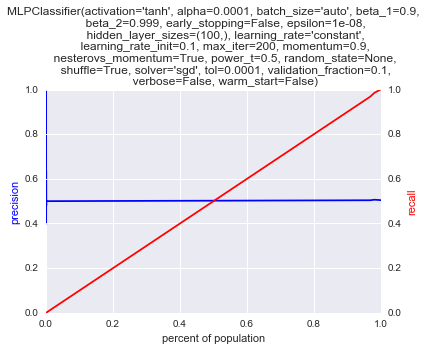

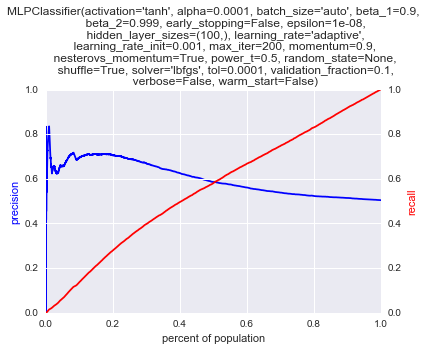

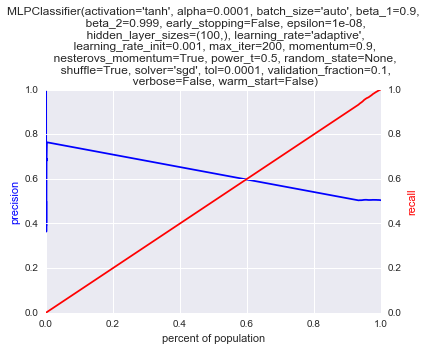

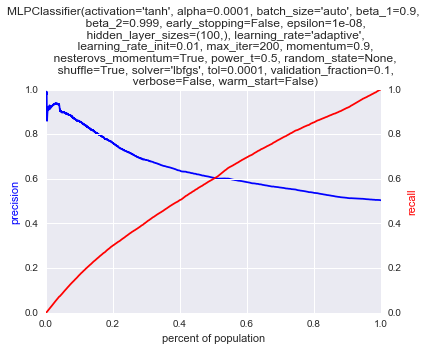

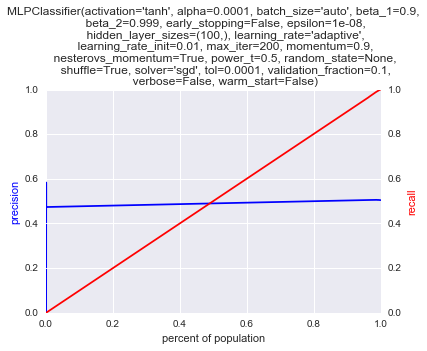

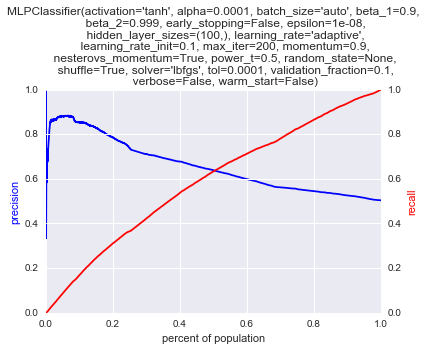

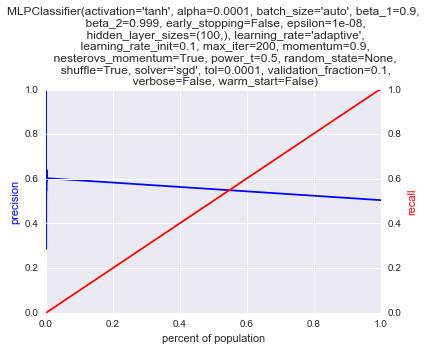

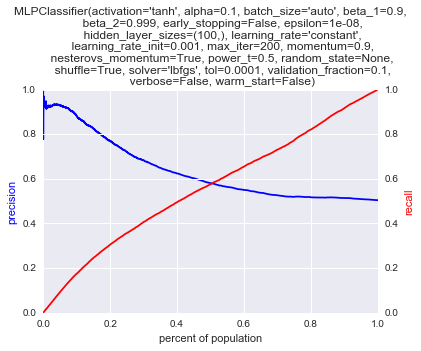

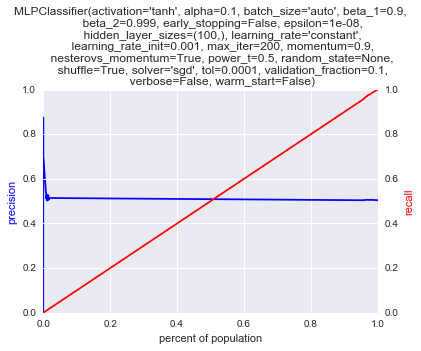

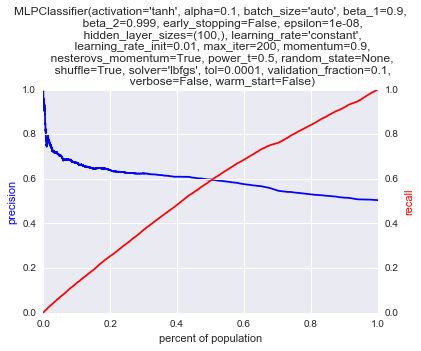

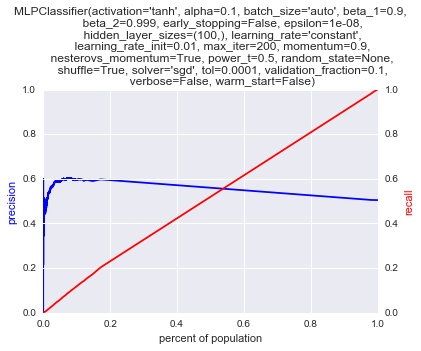

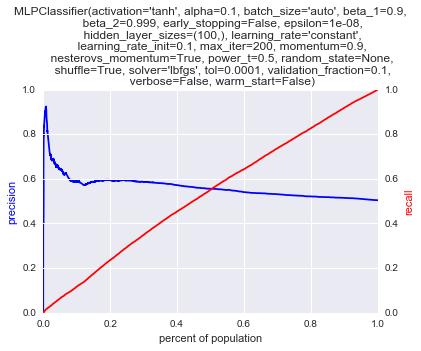

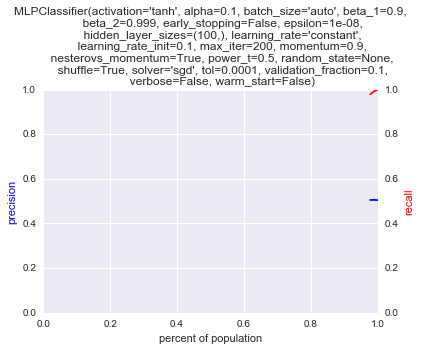

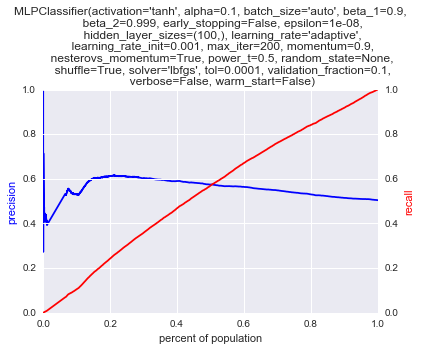

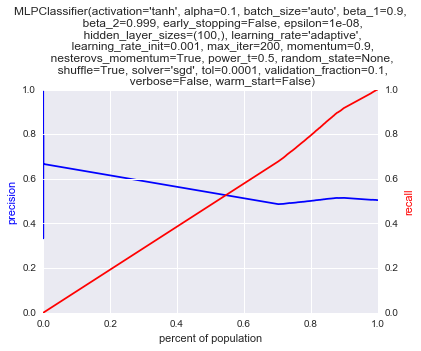

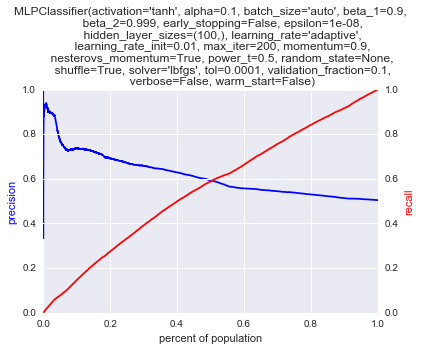

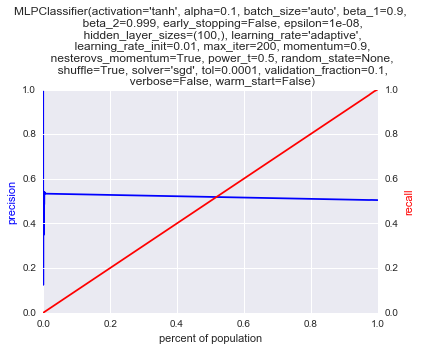

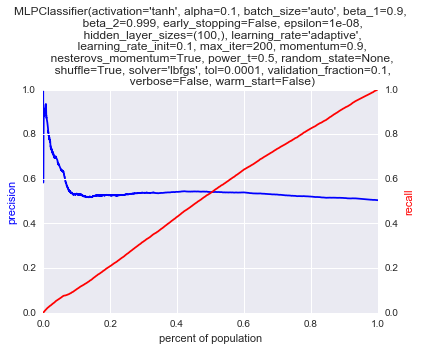

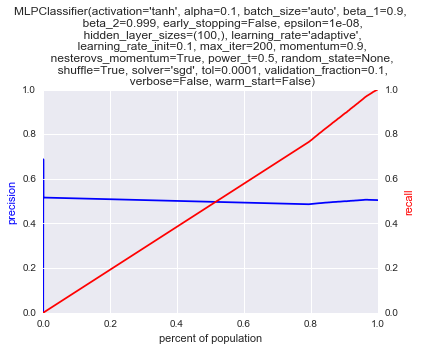

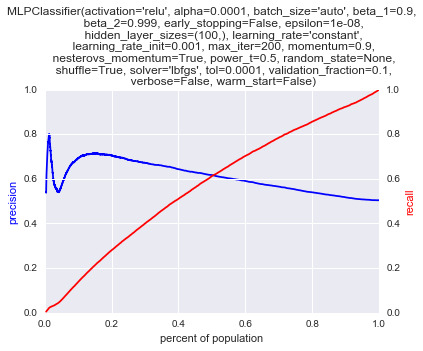

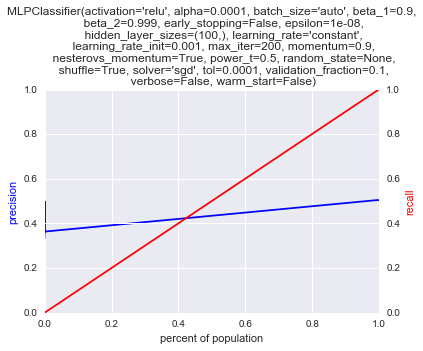

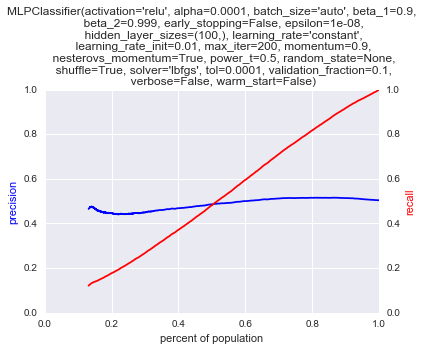

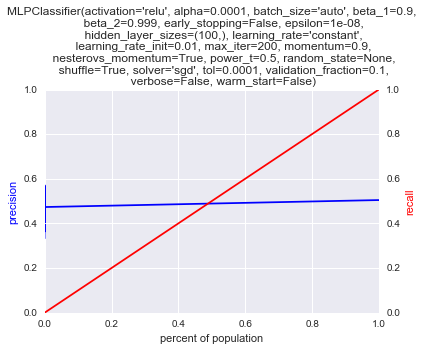

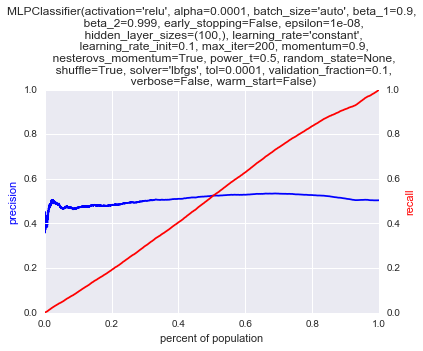

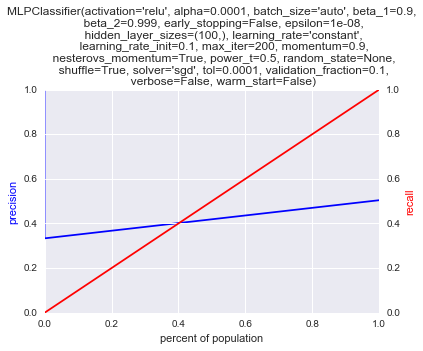

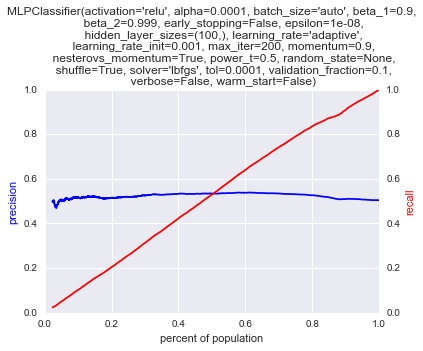

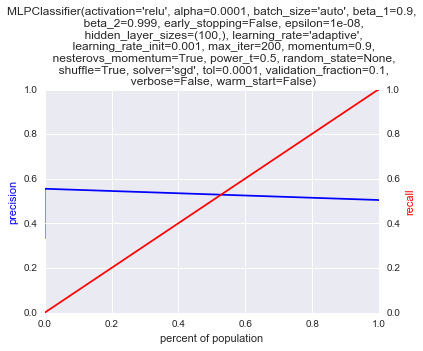

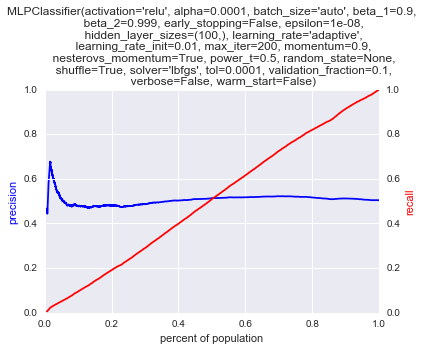

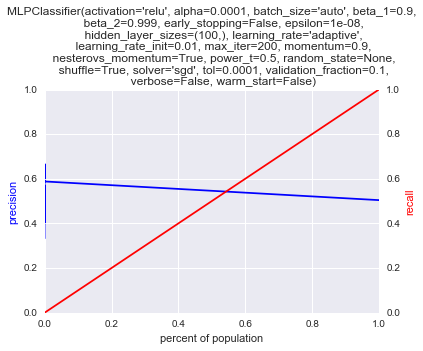

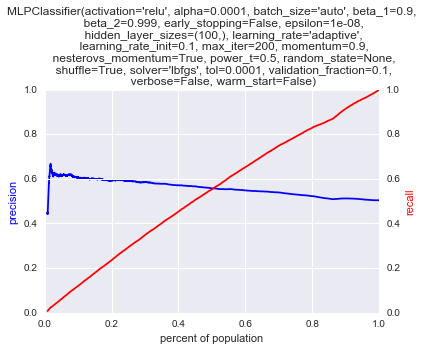

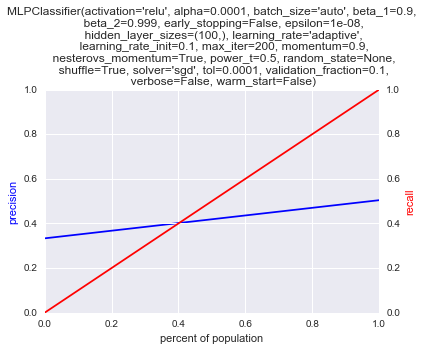

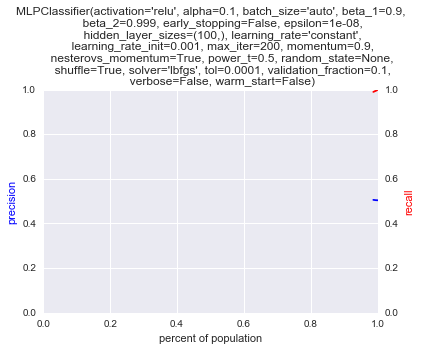

/Users/hannes/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


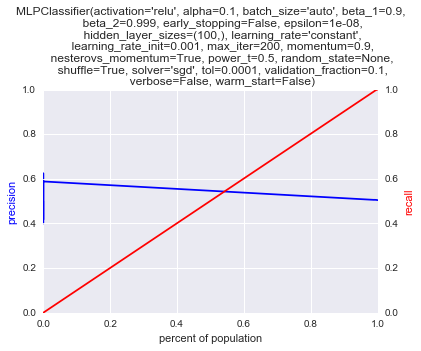

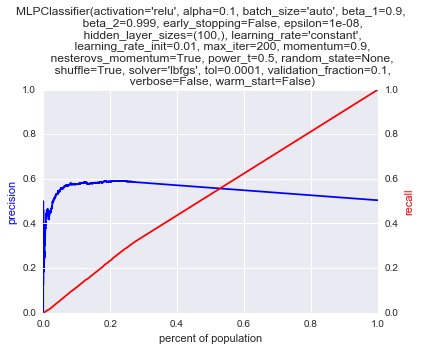

/Users/hannes/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


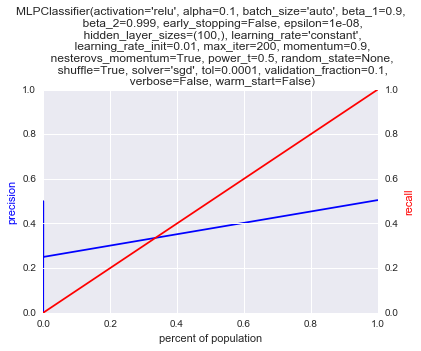

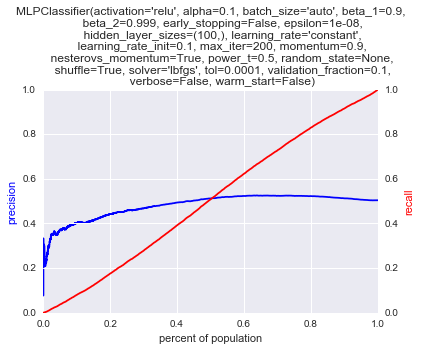

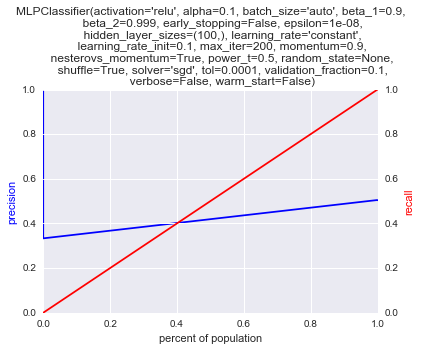

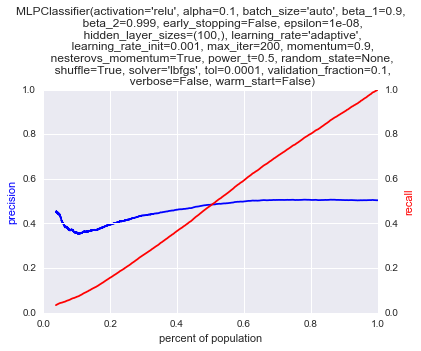

/Users/hannes/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


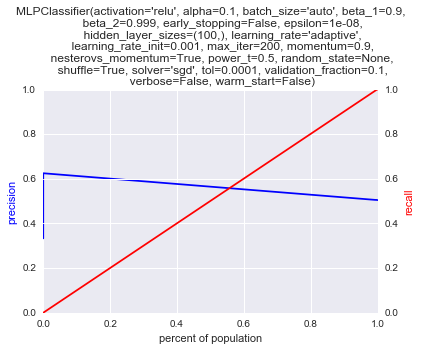

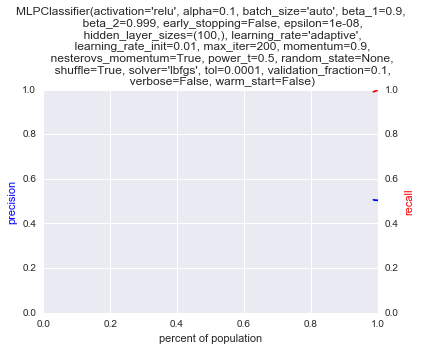

/Users/hannes/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


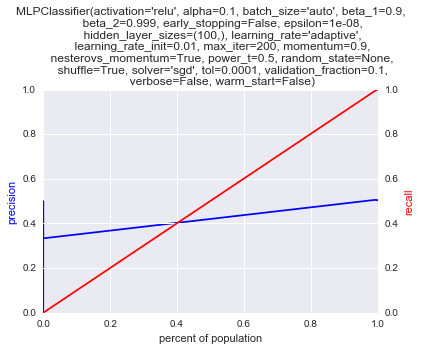

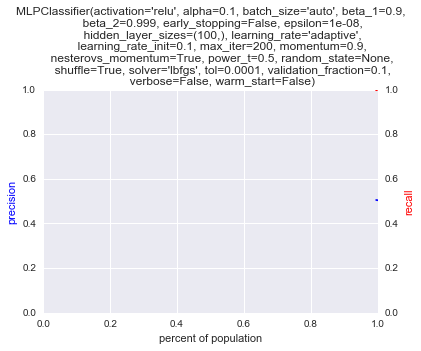

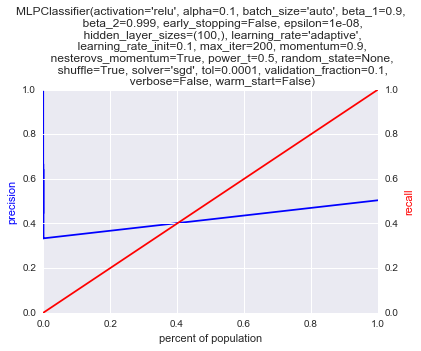

model_type                                                clf  \
0         LR  LogisticRegression(C=0.01, class_weight=None, ...   
1         LR  LogisticRegression(C=0.01, class_weight=None, ...   
2         LR  LogisticRegression(C=0.01, class_weight=None, ...   
3         LR  LogisticRegression(C=0.01, class_weight=None, ...   
4         LR  LogisticRegression(C=0.01, class_weight=None, ...   

                     parameters  train_time  predict_time  threshold  auc-roc  \
0  {'penalty': 'l1', 'C': 0.01}    3.397769      0.003941       0.30  0.78903   
1  {'penalty': 'l1', 'C': 0.01}    3.397769      0.003941       0.35  0.78903   
2  {'penalty': 'l1', 'C': 0.01}    3.397769      0.003941       0.40  0.78903   
3  {'penalty': 'l1', 'C': 0.01}    3.397769      0.003941       0.45  0.78903   
4  {'penalty': 'l1', 'C': 0.01}    3.397769      0.003941       0.50  0.78903   

   p_at_1  p_at_20  p_at_50     ...      p_at_150  p_at_200  p_at_All  \
0     1.0      1.0      1.0     ...           1.0       1.0  0.569952   
1     1.0      1.0      1.0     ...           1.0       1.0  0.596831   
2     1.0      1.0      1.0     ...           1.0       1.0  0.630837   
3     1.0      1.0      1.0     ...           1.0       1.0  0.687384   
4     1.0      1.0      1.0     ...           1.0       1.0  0.753961   

   rec_at_1  rec_at_20  rec_at_50  rec_at_100  rec_at_150  rec_at_200  \
0       1.0        1.0        1.0         1.0         1.0         1.0   
1       1.0        1.0        1.0         1.0         1.0         1.0   
2       1.0        1.0        1.0         1.0         1.0         1.0   
3       1.0        1.0        1.0         1.0         1.0         1.0   
4       1.0        1.0        1.0         1.0         1.0         1.0   

   rec_at_All  
0    0.947675  
1    0.905017  
2    0.848388  
3    0.745713  
4    0.641380  

[5 rows x 21 columns]

In [31]:
results_df_oversampling = predictions.clf_loop(models_to_run, clfs, grid, X_train_val, X_test_val, 
                                  y_train_val, y_test_val, list_ks, list_thresholds, print_plots = True)
results_df_oversampling.head()
results_df_oversampling.to_csv('results_oversampling.csv', index=False)

----
# Summary